In [1]:
import os

In [2]:
os.chdir("../core/")

In [3]:
%%capture
from load_datasets import *
from ensemble import *
from saliency import *
from scipy.stats import describe

In [4]:
(SVHN_trainX, SVHN_trainY),(SVHN_testX, SVHN_testY) = load_data("SVHN")
(MNIST_trainX, MNIST_trainY),(MNIST_testX, MNIST_testY) = load_data("MNIST")
NotMNIST = load_data("NotMNIST")
(CIFAR10_trainX, CIFAR10_trainY),(CIFAR10_testX, CIFAR10_testY) = load_data("CIFAR10")

../../datasets/notMNIST_small/A
Could not read: ../../datasets/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : Could not find a format to read the specified file in single-image mode - it's ok, skipping.
../../datasets/notMNIST_small/B
../../datasets/notMNIST_small/C
../../datasets/notMNIST_small/D
../../datasets/notMNIST_small/E
../../datasets/notMNIST_small/F
Could not read: ../../datasets/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png : Could not find a format to read the specified file in single-image mode - it's ok, skipping.
../../datasets/notMNIST_small/G
../../datasets/notMNIST_small/H
../../datasets/notMNIST_small/I
../../datasets/notMNIST_small/J


In [5]:
SVHN_trainX,SVHN_testX,CIFAR10_trainX,CIFAR10_testX = crop_32_to_28(SVHN_trainX),crop_32_to_28(SVHN_testX),crop_32_to_28(CIFAR10_trainX),crop_32_to_28(CIFAR10_testX)
SVHN_trainX,SVHN_testX,CIFAR10_trainX,CIFAR10_testX = make_monochrome(SVHN_trainX),make_monochrome(SVHN_testX),make_monochrome(CIFAR10_trainX),make_monochrome(CIFAR10_testX)

# Creating ensemble

In [6]:
MNIST_lenet = get_lenet(input_shape = np.shape(MNIST_trainX[0]))
train_network(network = MNIST_lenet, trainX = MNIST_trainX, trainY = MNIST_trainY)
MNIST_lenets = clone_network_into_ensemble(number_of_networks = 5, network = MNIST_lenet)
train_ensemble(ensemble = MNIST_lenets, trainX = MNIST_trainX, trainY = MNIST_trainY)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
60000/60000 [==============================] - 13s 220us/step - loss: 0.3845 - acc: 0.8939
Epoch 2/5
60000/60000 [==============================] - 10s 172us/step - loss: 0.1074 - acc: 0.9676
Epoch 3/5
60000/60000 [==============================] - 10s 170us/step - loss: 0.0753 - acc: 0.9770
Epoch 4/5
60000/60000 [==============================] - 10s 170us/step - loss: 0.0595 - acc: 0.9817
Epoch 5/5
60000/60000 [==============================] - 10s 168us/step - loss: 0.0497 - acc: 0.9849
Epoch 1/5
60000/60000 [==============================] - 11s 182us/step - loss: 0.4354 - acc: 0.8756
Epoch 2/5
60000/60000 [==============================] - 10s 170us/step - loss: 0.1128 - acc: 0.9663
Epoch 3/5
60000/60000 [==============================] - 10s 172us/step - loss: 0.0784 - acc: 0.9765
Epoch 4/5
60000/60000 [==============================] - 10s 171us/step - loss: 0.0611 - acc: 0.9812
Epoch 5/5
60000/60000 [==============================] - 10s 171us/step - loss: 0.0511 - ac

In [7]:
MNIST_optimizers = get_ensemble_optimisers(ensemble = MNIST_lenets, grad_cam = True)

# Extracting data

## MNIST

In [8]:
MNIST_outputs_values = get_ensemble_output_values_for_multiple_inputs(ensemble = MNIST_lenets, inputs = MNIST_testX, number_of_output_nodes = 10)
MNIST_predicted_outputs = get_ensemble_predicted_outputs(ensemble = MNIST_lenets, inputs = MNIST_testX, number_of_output_nodes = 10)
MNIST_output_values_of_predicted_outputs = np.take(MNIST_outputs_values,MNIST_predicted_outputs)

In [9]:
MNIST_ensemble_votes = get_ensemble_votes_for_multiple_inputs(MNIST_lenets,MNIST_testX,10)
MNIST_majority_voting_predicted_outputs = np.argmax(MNIST_ensemble_votes,axis = 1)
MNIST_vote_ratios_of_predicted_outputs = np.max(MNIST_ensemble_votes,axis = 1)/5
MNIST_different_instances_between_voting_and_averaging = np.nonzero(MNIST_majority_voting_predicted_outputs-MNIST_predicted_outputs)[0]

In [51]:
import importlib, sys
importlib.reload(sys.modules['saliency'])
from saliency import calculate_uncertainties_with_maps

In [52]:
MNIST_saliency_maps = generate_ensemble_saliency_maps_for_multiple_inputs(
    ensemble = MNIST_lenets,
    inputs = MNIST_testX,
    output_nodes = MNIST_predicted_outputs,
    optimisers = MNIST_optimizers,
    visualised_layer = 9,
    grad_cam = True)

MNIST_uncertainties = calculate_uncertainties_with_maps(MNIST_saliency_maps)

100%|██████████| 10000/10000 [00:39<00:00, 251.29it/s]


In [53]:
MNIST_singular_predictions_values = MNIST_lenet.predict(MNIST_testX)

In [54]:
MNIST_variance = np.var(MNIST_singular_predictions_values,axis = 1)

## NotMNIST

In [57]:
NotMNIST_outputs_values = get_ensemble_output_values_for_multiple_inputs(ensemble = MNIST_lenets, inputs = NotMNIST, number_of_output_nodes = 10)
NotMNIST_predicted_outputs = get_ensemble_predicted_outputs(ensemble = MNIST_lenets, inputs = NotMNIST, number_of_output_nodes = 10)
NotMNIST_output_values_of_predicted_outputs = np.take(NotMNIST_outputs_values,NotMNIST_predicted_outputs)

In [58]:
NotMNIST_ensemble_votes = get_ensemble_votes_for_multiple_inputs(MNIST_lenets,NotMNIST,10)
NotMNIST_majority_voting_predicted_outputs = np.argmax(NotMNIST_ensemble_votes,axis = 1)
NotMNIST_vote_ratios_of_predicted_outputs = np.max(NotMNIST_ensemble_votes,axis = 1)/5
NotMNIST_different_instances_between_voting_and_averaging = np.nonzero(NotMNIST_majority_voting_predicted_outputs-NotMNIST_predicted_outputs)[0]

In [59]:
NotMNIST_saliency_maps = generate_ensemble_saliency_maps_for_multiple_inputs(
    ensemble = MNIST_lenets,
    inputs = NotMNIST,
    output_nodes = NotMNIST_predicted_outputs,
    optimisers = MNIST_optimizers,
    visualised_layer = 9,
    grad_cam = True)

NotMNIST_uncertainties = calculate_uncertainties_with_maps(NotMNIST_saliency_maps)

100%|██████████| 18724/18724 [01:14<00:00, 252.27it/s]


In [60]:
NotMNIST_singular_predictions_values = MNIST_lenet.predict(NotMNIST)

In [61]:
NotMNIST_variance = np.var(NotMNIST_singular_predictions_values,axis = 1)

## SVHN

In [62]:
SVHN_outputs_values = get_ensemble_output_values_for_multiple_inputs(ensemble = MNIST_lenets, inputs = SVHN_testX, number_of_output_nodes = 10)
SVHN_predicted_outputs = get_ensemble_predicted_outputs(ensemble = MNIST_lenets, inputs = SVHN_testX, number_of_output_nodes = 10)
SVHN_output_values_of_predicted_outputs = np.take(SVHN_outputs_values,SVHN_predicted_outputs)

In [63]:
SVHN_ensemble_votes = get_ensemble_votes_for_multiple_inputs(MNIST_lenets,SVHN_testX,10)
SVHN_majority_voting_predicted_outputs = np.argmax(SVHN_ensemble_votes,axis = 1)
SVHN_vote_ratios_of_predicted_outputs = np.max(SVHN_ensemble_votes,axis = 1)/5
SVHN_different_instances_between_voting_and_averaging = np.nonzero(SVHN_majority_voting_predicted_outputs-SVHN_predicted_outputs)[0]

In [64]:
SVHN_saliency_maps = generate_ensemble_saliency_maps_for_multiple_inputs(
    ensemble = MNIST_lenets,
    inputs = SVHN_testX,
    output_nodes = SVHN_predicted_outputs,
    optimisers = MNIST_optimizers,
    visualised_layer = 9,
    grad_cam = True)

SVHN_uncertainties = calculate_uncertainties_with_maps(SVHN_saliency_maps)

100%|██████████| 26032/26032 [01:38<00:00, 264.67it/s]


In [65]:
SVHN_singular_predictions_values = MNIST_lenet.predict(SVHN_testX)

In [66]:
SVHN_variance = np.var(SVHN_singular_predictions_values,axis = 1)

## CIFAR10

In [67]:
CIFAR10_outputs_values = get_ensemble_output_values_for_multiple_inputs(ensemble = MNIST_lenets, inputs = CIFAR10_testX, number_of_output_nodes = 10)
CIFAR10_predicted_outputs = get_ensemble_predicted_outputs(ensemble = MNIST_lenets, inputs = CIFAR10_testX, number_of_output_nodes = 10)
CIFAR10_output_values_of_predicted_outputs = np.take(CIFAR10_outputs_values,CIFAR10_predicted_outputs)

In [68]:
CIFAR10_ensemble_votes = get_ensemble_votes_for_multiple_inputs(MNIST_lenets,CIFAR10_testX,10)
CIFAR10_majority_voting_predicted_outputs = np.argmax(CIFAR10_ensemble_votes,axis = 1)
CIFAR10_vote_ratios_of_predicted_outputs = np.max(CIFAR10_ensemble_votes,axis = 1)/5
CIFAR10_different_instances_between_voting_and_averaging = np.nonzero(CIFAR10_majority_voting_predicted_outputs-CIFAR10_predicted_outputs)[0]

In [69]:
CIFAR10_saliency_maps = generate_ensemble_saliency_maps_for_multiple_inputs(
    ensemble = MNIST_lenets,
    inputs = CIFAR10_testX,
    output_nodes = CIFAR10_predicted_outputs,
    optimisers = MNIST_optimizers,
    visualised_layer = 9,
    grad_cam = True)

CIFAR10_uncertainties = calculate_uncertainties_with_maps(CIFAR10_saliency_maps)

100%|██████████| 10000/10000 [00:37<00:00, 264.68it/s]


In [70]:
CIFAR10_singular_predictions_values = MNIST_lenet.predict(CIFAR10_testX)

In [71]:
CIFAR10_variance = np.var(CIFAR10_singular_predictions_values,axis = 1)

# Exploring data

In [72]:
# General evaluation
print("Evaluation (loss,acc) of singular LeNet:")
print(MNIST_lenet.evaluate(MNIST_testX, MNIST_testY))
print("")
print("Evaluation (loss,acc) of each LeNet in the ensemble:")
for lenet in MNIST_lenets:
    print(lenet.evaluate(MNIST_testX, MNIST_testY))
print("")
print("Accuracy of ensemble:")
print(evaluate_ensemble_accuracy(MNIST_lenets,MNIST_testX,MNIST_testY))
print("")
print("Averaged softmax output values of any output node of the ensemble:")
print(describe(MNIST_outputs_values,axis=None))
print("")
print("Averaged softmax output values of the ensemble's predicted outputs:")
print(describe(MNIST_output_values_of_predicted_outputs))
print("")
print("Softmax output values of the singular LeNet's outputs:")
print(describe(MNIST_lenet.predict(MNIST_testX),axis = None))
print("")

Evaluation (loss,acc) of singular LeNet:
10000/10000 [==============================] - 1s 102us/step
[0.042771698893094436, 0.9851]

Evaluation (loss,acc) of each LeNet in the ensemble:
10000/10000 [==============================] - 1s 99us/step
[0.043037079458730296, 0.9856]
10000/10000 [==============================] - 1s 97us/step
[0.042122876685578375, 0.9853]
10000/10000 [==============================] - 1s 98us/step
[0.05035250207579229, 0.9831]
10000/10000 [==============================] - 1s 98us/step
[0.04534912034505978, 0.9856]
10000/10000 [==============================] - 1s 98us/step
[0.044442255686828865, 0.9848]

Accuracy of ensemble:
0.9868

Averaged softmax output values of any output node of the ensemble:
DescribeResult(nobs=100000, minmax=(5.7172791438959196e-18, 0.9999999761581421), mean=0.1000000002823566, variance=0.08691028188739464, skewness=2.671830313605337, kurtosis=5.186525895272709)

Averaged softmax output values of the ensemble's predicted outputs:
D

## MNIST

In [73]:
plt.style.use('default')

Statistical description of uncertainty values:
DescribeResult(nobs=10000, minmax=(0.26481421249426396, 1.9974489795918366), mean=0.45415545438857136, variance=0.02438661920076262, skewness=3.362878238297256, kurtosis=15.712200178003911)
Histogram of uncertainty values:


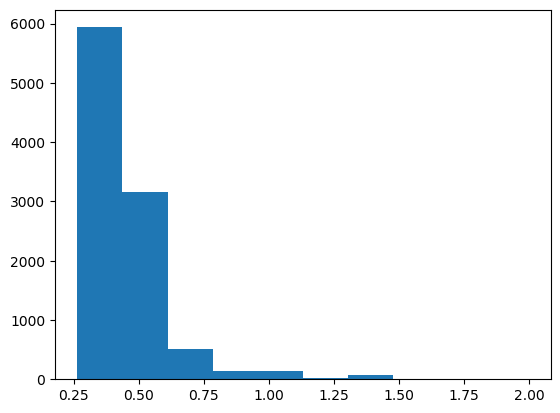

In [74]:
print("Statistical description of uncertainty values:")
print(describe(MNIST_uncertainties))
print("Histogram of uncertainty values:")
plt.hist(MNIST_uncertainties)
plt.show()

Scatterplot of softmax value of predicted output (x) and uncertainty (y):


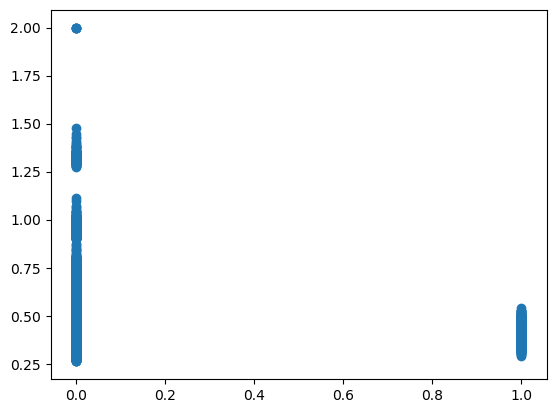

In [75]:
plt.scatter(x = MNIST_output_values_of_predicted_outputs, y = MNIST_uncertainties)
print("Scatterplot of softmax value of predicted output (x) and uncertainty (y):")
plt.show()

Variance of singular LeNet's outputs for each input
DescribeResult(nobs=10000, minmax=(0.010750219, 0.08999999), mean=0.08737523, variance=8.0708654e-05, skewness=-4.772006988525391, kurtosis=24.02476297263106)


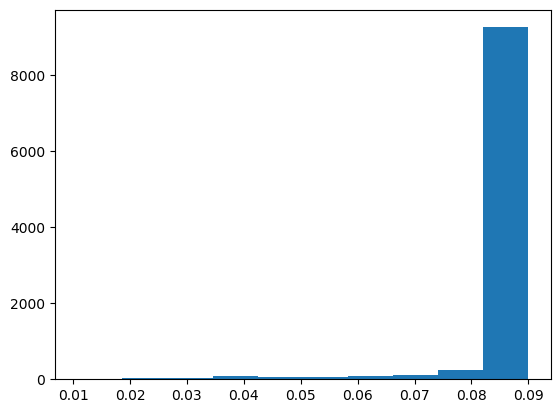

In [76]:
print("Variance of singular LeNet's outputs for each input")
print(describe(MNIST_variance))
plt.hist(MNIST_variance)
plt.show()

15
0.9985
DescribeResult(nobs=10000, minmax=(0.4, 1.0), mean=0.9931, variance=0.002316621662166217, skewness=-7.639772994622177, kurtosis=61.645976440740796)


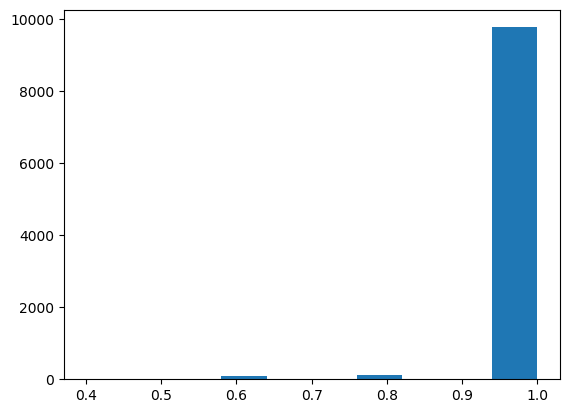

In [77]:
print(len(MNIST_different_instances_between_voting_and_averaging))
print(1 - len(MNIST_different_instances_between_voting_and_averaging)/len(MNIST_testX))
print(describe(MNIST_vote_ratios_of_predicted_outputs))
plt.hist(MNIST_vote_ratios_of_predicted_outputs)
plt.show()

## NotMNIST

Statistical description of uncertainty values:
DescribeResult(nobs=18724, minmax=(0.19159750018346763, 1.9974489795918366), mean=0.3980673064128991, variance=0.008903772368127937, skewness=2.751624404923166, kurtosis=16.280516207586068)
Histogram of uncertainty values:


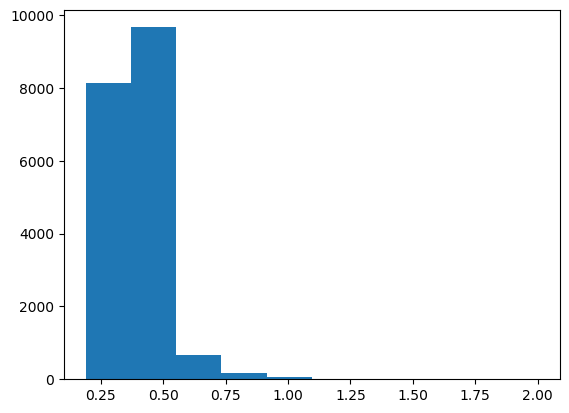

In [78]:
print("Statistical description of uncertainty values:")
print(describe(NotMNIST_uncertainties))
print("Histogram of uncertainty values:")
plt.hist(NotMNIST_uncertainties)
plt.show()

Scatterplot of softmax value of predicted output (x) and uncertainty (y):


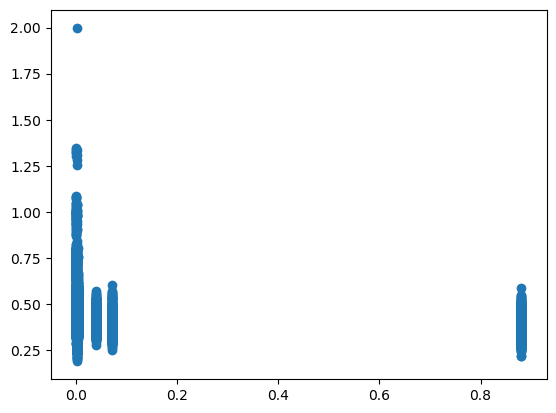

In [79]:
plt.scatter(x = NotMNIST_output_values_of_predicted_outputs, y = NotMNIST_uncertainties)
print("Scatterplot of softmax value of predicted output (x) and uncertainty (y):")
plt.show()

Variance of singular LeNet's outputs for each input
DescribeResult(nobs=18724, minmax=(7.3978634e-05, 0.08999391), mean=0.039733175, variance=0.000585738, skewness=0.5028476715087891, kurtosis=-0.8242574946812731)


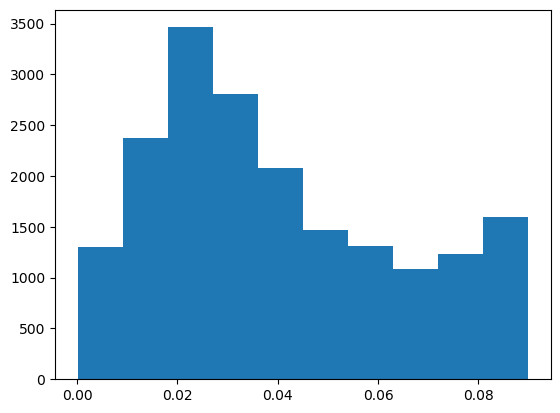

In [80]:
print("Variance of singular LeNet's outputs for each input")
print(describe(NotMNIST_variance))
plt.hist(NotMNIST_variance)
plt.show()

DescribeResult(nobs=18724, minmax=(0.2, 1.0), mean=0.8104998931852168, variance=0.040603307215712564, skewness=-0.6193457170094782, kurtosis=-0.8511792578180484)


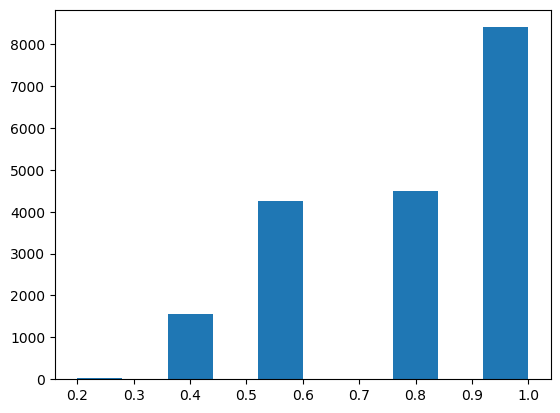

In [81]:
print(describe(NotMNIST_vote_ratios_of_predicted_outputs))
plt.hist(NotMNIST_vote_ratios_of_predicted_outputs)
plt.show()

## SVHN

Statistical description of uncertainty values:
DescribeResult(nobs=26032, minmax=(0.18571740875603218, 1.4629097029981892), mean=0.4147419313423107, variance=0.004800691767894525, skewness=1.6928867566807653, kurtosis=14.91156405010397)
Histogram of uncertainty values:


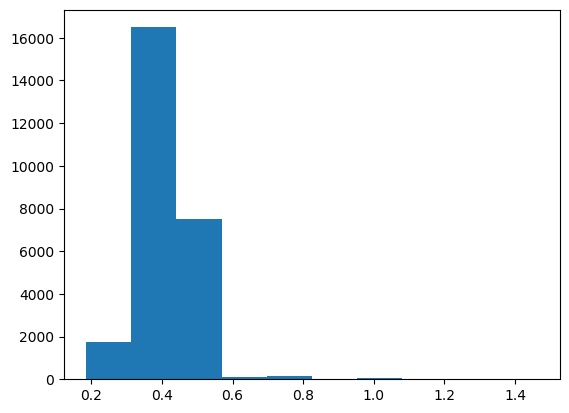

In [82]:
print("Statistical description of uncertainty values:")
print(describe(SVHN_uncertainties))
print("Histogram of uncertainty values:")
plt.hist(SVHN_uncertainties)
plt.show()

Scatterplot of softmax value of predicted output (x) and uncertainty (y):


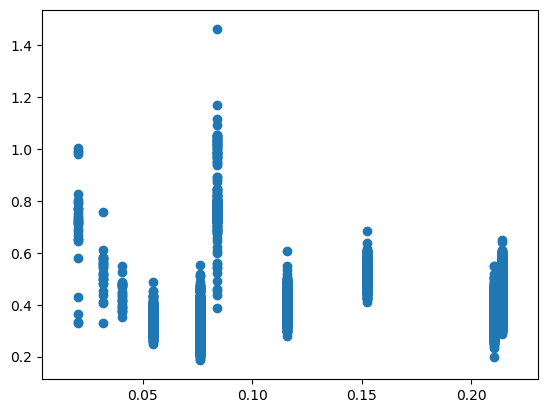

In [83]:
plt.scatter(x = SVHN_output_values_of_predicted_outputs, y = SVHN_uncertainties)
print("Scatterplot of softmax value of predicted output (x) and uncertainty (y):")
plt.show()

Variance of singular LeNet's outputs for each input
DescribeResult(nobs=26032, minmax=(0.0009445768, 0.08997848), mean=0.029382894, variance=0.00033087068, skewness=1.0655757188796997, kurtosis=0.6835757005141594)


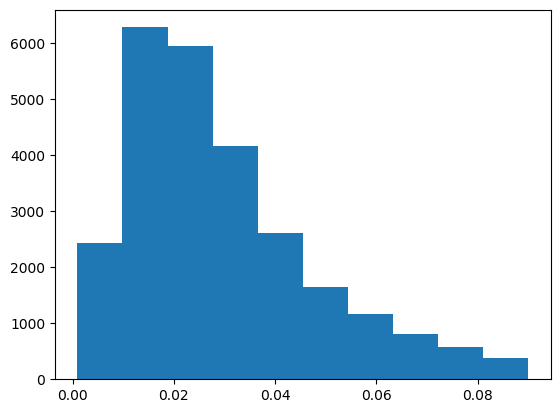

In [84]:
print("Variance of singular LeNet's outputs for each input")
print(describe(SVHN_variance))
plt.hist(SVHN_variance)
plt.show()

1548
0.9405347264904733
DescribeResult(nobs=26032, minmax=(0.2, 1.0), mean=0.8450522433927473, variance=0.03629990123118535, skewness=-0.916906640855517, kurtosis=-0.314713473085829)


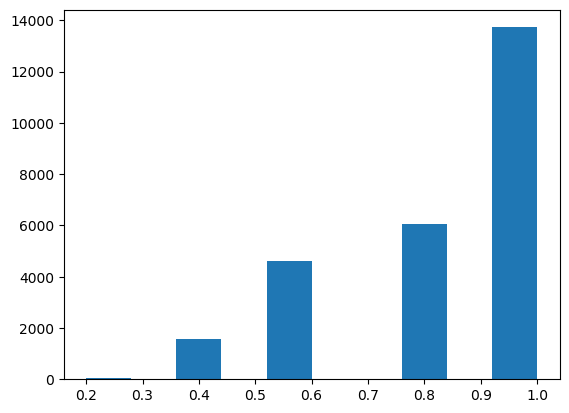

In [85]:
print(len(SVHN_different_instances_between_voting_and_averaging))
print(1 - len(SVHN_different_instances_between_voting_and_averaging)/len(SVHN_testX))
print(describe(SVHN_vote_ratios_of_predicted_outputs))
plt.hist(SVHN_vote_ratios_of_predicted_outputs)
plt.show()

## CIFAR10

Statistical description of uncertainty values:
DescribeResult(nobs=10000, minmax=(0.19110694086308322, 1.3505491870799156), mean=0.3840984511760478, variance=0.006864982616471901, skewness=1.824585970674786, kurtosis=13.38143580687116)
Histogram of uncertainty values:


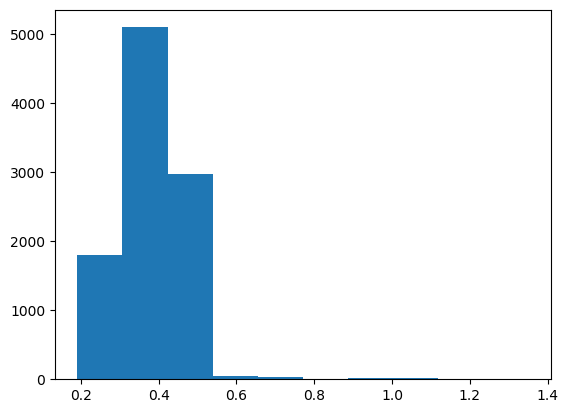

In [86]:
print("Statistical description of uncertainty values:")
print(describe(CIFAR10_uncertainties))
print("Histogram of uncertainty values:")
plt.hist(CIFAR10_uncertainties)
plt.show()

Scatterplot of softmax value of predicted output (x) and uncertainty (y):


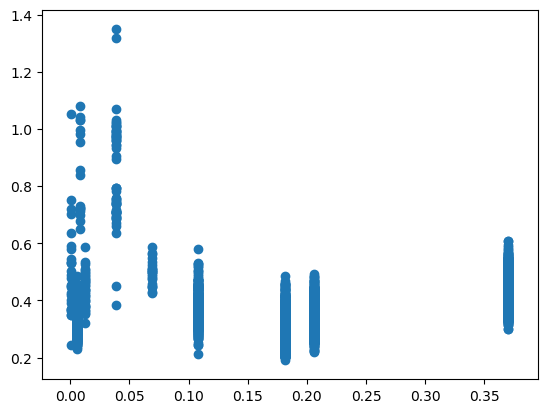

In [87]:
plt.scatter(x = CIFAR10_output_values_of_predicted_outputs, y = CIFAR10_uncertainties)
print("Scatterplot of softmax value of predicted output (x) and uncertainty (y):")
plt.show()

Variance of singular LeNet's outputs for each input
DescribeResult(nobs=10000, minmax=(0.003698239, 0.08993219), mean=0.037565492, variance=0.00037496653, skewness=0.7874618172645569, kurtosis=-0.19312213738848216)


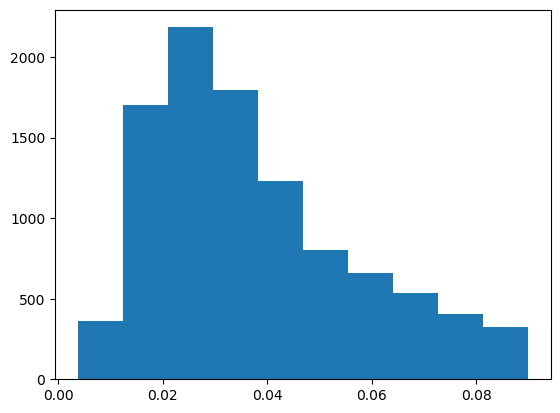

In [88]:
print("Variance of singular LeNet's outputs for each input")
print(describe(CIFAR10_variance))
plt.hist(CIFAR10_variance)
plt.show()

992
0.9008
DescribeResult(nobs=10000, minmax=(0.2, 1.0), mean=0.7677, variance=0.04291700170017002, skewness=-0.30823445368831315, kurtosis=-1.1358935092994127)


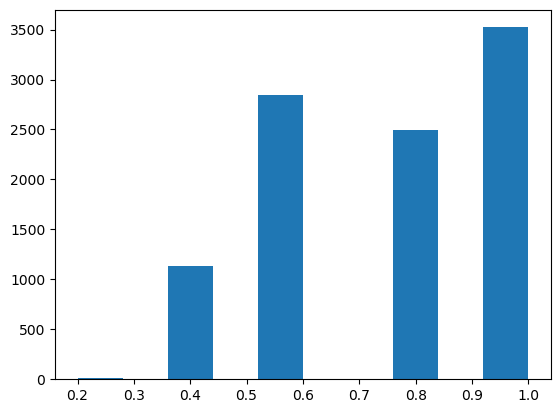

In [89]:
print(len(CIFAR10_different_instances_between_voting_and_averaging))
print(1 - len(CIFAR10_different_instances_between_voting_and_averaging)/len(CIFAR10_testX))
print(describe(CIFAR10_vote_ratios_of_predicted_outputs))
plt.hist(CIFAR10_vote_ratios_of_predicted_outputs)
plt.show()